# Load Data

In [1]:
import os
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [6]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.cast(img, tf.float32)/255.0
    return img

## Load Images

In [7]:
train_images = tf.data.Dataset.list_files('image_data/aug_data_face/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)

In [8]:
val_images = tf.data.Dataset.list_files('image_data/aug_data_face/validation/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)

## Load Labels

In [9]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [10]:
train_labels = tf.data.Dataset.list_files('image_data/aug_data_face/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [11]:
val_labels = tf.data.Dataset.list_files('image_data/aug_data_face/validation/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [12]:
len(train_images), len(train_labels), len(val_images), len(val_labels)

(16000, 16000, 4000, 4000)

## Load Dataset

In [13]:
train = tf.data.Dataset.zip((train_images, train_labels)).cache()
train = train.shuffle(len(train_images)//3)
train = train.batch(4)
train = train.prefetch(tf.data.AUTOTUNE)

In [14]:
val = tf.data.Dataset.zip((val_images, val_labels)).cache()
val = val.batch(4)
val = val.prefetch(tf.data.AUTOTUNE)

# Nyoba Model

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D 
from tensorflow.keras.applications import VGG16, MobileNetV2, InceptionV3, Xception, MobileNetV3Large, InceptionResNetV2, MobileNetV3Small   

In [13]:
mobilenetv3s = MobileNetV3Small(include_top=False, input_shape=(200, 200, 3), include_preprocessing=False)
mobilenetv3s.trainable = False

In [37]:
input_layer = Input(shape=(200,200,3))

x = mobilenetv3s(input_layer, training=False)

# Classification Model  
f1 = GlobalAveragePooling2D()(x)
drop1 = Dropout(0.35)(f1)
class2 = Dense(1, activation='sigmoid', name='face')(drop1)

# Bounding box model
f2 = GlobalAveragePooling2D()(x)
drop2 = Dropout(0.2)(f2)
regress2 = Dense(4, activation='sigmoid', name='bbox')(drop2)

model = Model(inputs=input_layer, outputs=[class2, regress2])

In [38]:
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay (
  initial_learning_rate,
  decay_steps=10000,
  decay_rate=0.93,
  staircase=True)

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule, amsgrad=True)

In [148]:
initial_learning_rate = 5e-5
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay (
  initial_learning_rate,
  decay_steps=10000,
  decay_rate=0.96,
  staircase=True)

opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.99)

In [3]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [42]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights = True)

In [43]:
model.compile(optimizer=opt, loss=['binary_crossentropy', localization_loss],loss_weights=[10, 1] )

In [44]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[callback])

Epoch 1/20
4000/4000 [==============================] - 101s 22ms/step - loss: 4.7355 - face_loss: 0.3885 - bbox_loss: 0.8506 - val_loss: 3.4623 - val_face_loss: 0.2900 - val_bbox_loss: 0.5620
Epoch 2/20
4000/4000 [==============================] - 92s 23ms/step - loss: 3.4485 - face_loss: 0.2878 - bbox_loss: 0.5707 - val_loss: 3.0765 - val_face_loss: 0.2575 - val_bbox_loss: 0.5016
Epoch 3/20
4000/4000 [==============================] - 93s 23ms/step - loss: 3.1535 - face_loss: 0.2628 - bbox_loss: 0.5253 - val_loss: 2.8920 - val_face_loss: 0.2420 - val_bbox_loss: 0.4716
Epoch 4/20
4000/4000 [==============================] - 99s 25ms/step - loss: 3.0282 - face_loss: 0.2526 - bbox_loss: 0.5019 - val_loss: 2.8136 - val_face_loss: 0.2356 - val_bbox_loss: 0.4574
Epoch 5/20
4000/4000 [==============================] - 98s 24ms/step - loss: 2.9202 - face_loss: 0.2431 - bbox_loss: 0.4896 - val_loss: 2.7753 - val_face_loss: 0.2320 - val_bbox_loss: 0.4553
Epoch 6/20
4000/4000 [=================

In [33]:
hist = model.fit(train, epochs=5, validation_data=val, callbacks=[callback])

Epoch 1/5
4000/4000 [==============================] - 315s 55ms/step - loss: 4.6652 - face_loss: 0.3842 - bbox_loss: 0.8236 - val_loss: 3.4084 - val_face_loss: 0.2856 - val_bbox_loss: 0.5528
Epoch 2/5
4000/4000 [==============================] - 130s 32ms/step - loss: 3.4375 - face_loss: 0.2868 - bbox_loss: 0.5698 - val_loss: 3.0334 - val_face_loss: 0.2536 - val_bbox_loss: 0.4978
Epoch 3/5
4000/4000 [==============================] - 134s 33ms/step - loss: 3.1417 - face_loss: 0.2620 - bbox_loss: 0.5213 - val_loss: 2.8608 - val_face_loss: 0.2392 - val_bbox_loss: 0.4685
Epoch 4/5
4000/4000 [==============================] - 126s 31ms/step - loss: 3.0304 - face_loss: 0.2528 - bbox_loss: 0.5027 - val_loss: 2.7829 - val_face_loss: 0.2328 - val_bbox_loss: 0.4553
Epoch 5/5
4000/4000 [==============================] - 118s 29ms/step - loss: 2.9175 - face_loss: 0.2434 - bbox_loss: 0.4832 - val_loss: 2.7286 - val_face_loss: 0.2284 - val_bbox_loss: 0.44439187 - face_loss: 


## Mobilenet v2

### global avg

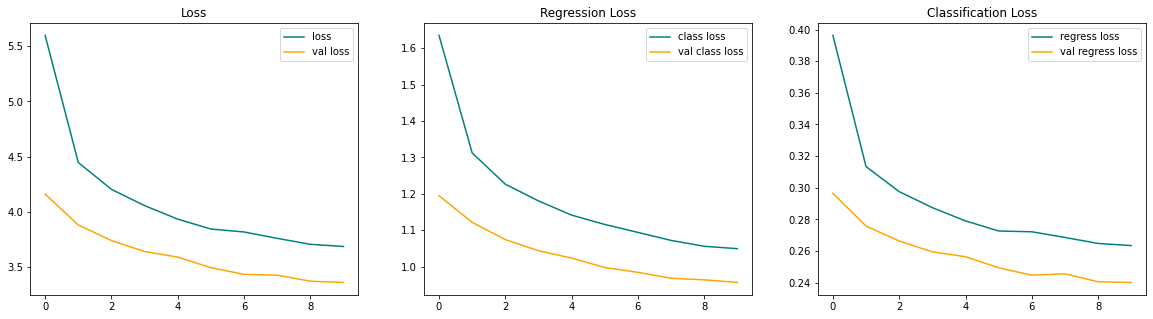

In [33]:
#mv2 max
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['bbox_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_bbox_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Regression Loss')
ax[1].legend()

ax[2].plot(hist.history['face_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_face_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Classification Loss')
ax[2].legend()

plt.show()

### global max

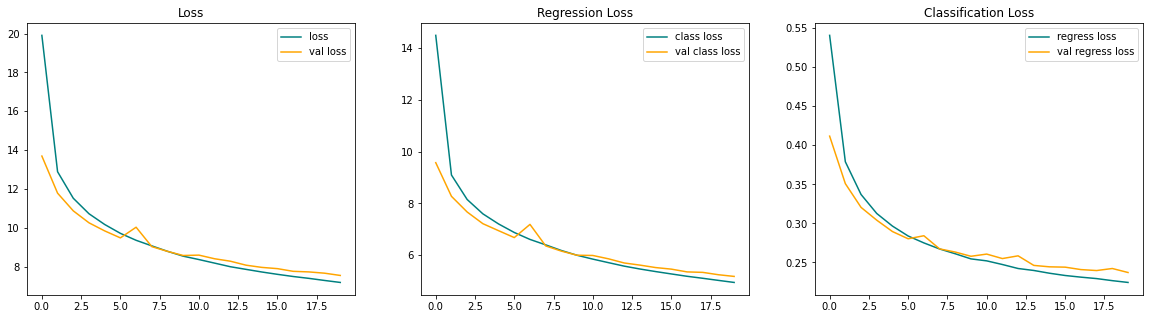

In [164]:
#mv2 max
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['bbox_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_bbox_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Regression Loss')
ax[1].legend()

ax[2].plot(hist.history['face_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_face_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Classification Loss')
ax[2].legend()

plt.show()

## Mobilenet v3 small

### global avg sgd

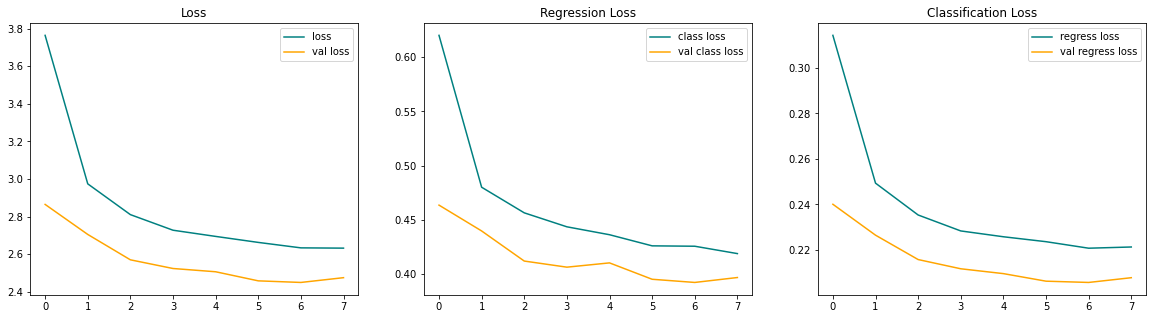

In [20]:
#mv2 max
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['bbox_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_bbox_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Regression Loss')
ax[1].legend()

ax[2].plot(hist.history['face_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_face_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Classification Loss')
ax[2].legend()

plt.show()

### global avg adam

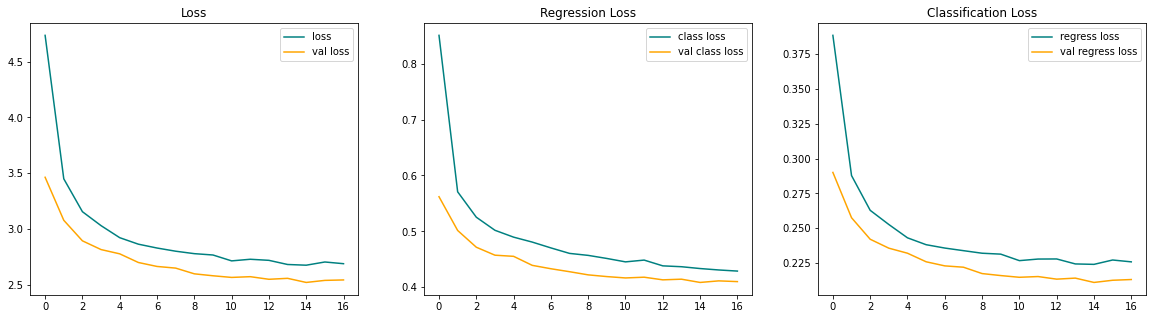

In [45]:
#mv2 max
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['bbox_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_bbox_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Regression Loss')
ax[1].legend()

ax[2].plot(hist.history['face_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_face_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Classification Loss')
ax[2].legend()

plt.show()

## Mobilenet v3 large

### global avg

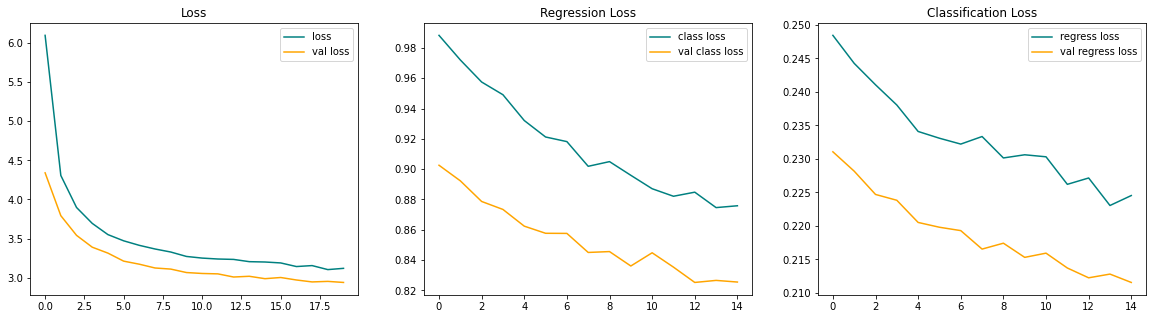

In [104]:
#mv2 max
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['bbox_loss'][5:], color='teal', label='class loss')
ax[1].plot(hist.history['val_bbox_loss'][5:], color='orange', label='val class loss')
ax[1].title.set_text('Regression Loss')
ax[1].legend()

ax[2].plot(hist.history['face_loss'][5:], color='teal', label='regress loss')
ax[2].plot(hist.history['val_face_loss'][5:], color='orange', label='val regress loss')
ax[2].title.set_text('Classification Loss')
ax[2].legend()

plt.show()

### global max

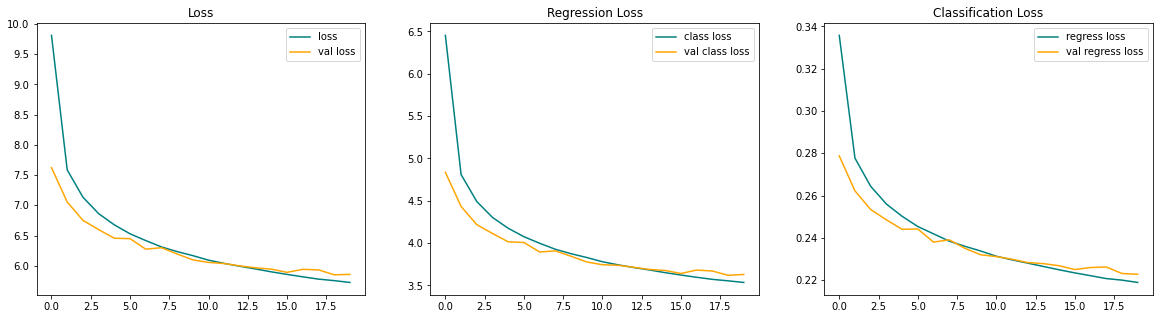

In [185]:
#mv2 max
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['bbox_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_bbox_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Regression Loss')
ax[1].legend()

ax[2].plot(hist.history['face_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_face_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Classification Loss')
ax[2].legend()

plt.show()

### global avg

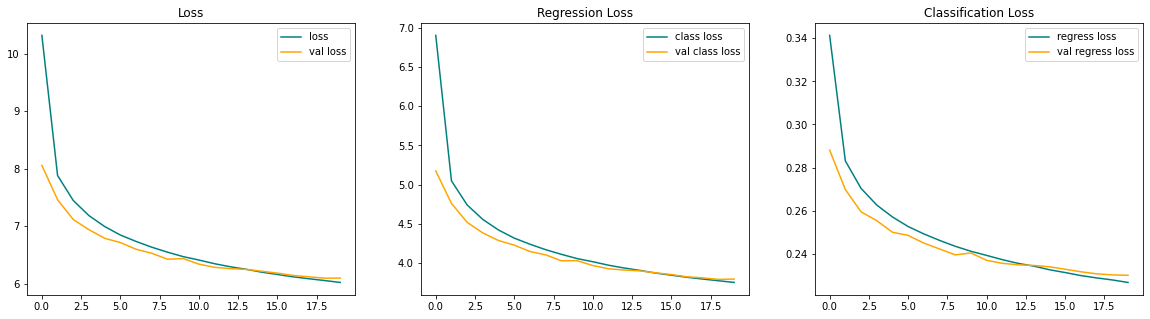

In [175]:
#mv2 avg 0.0001
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['bbox_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_bbox_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Regression Loss')
ax[1].legend()

ax[2].plot(hist.history['face_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_face_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Classification Loss')
ax[2].legend()

plt.show()

In [46]:
mobilenetv3s.trainable = True

In [162]:
mobilenetv3s.layers[179]

In [47]:
for layer in mobilenetv3s.layers[:191]:
  layer.trainable = False

In [48]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
MobilenetV3small (Functional)   (None, 1, 1, 1024)   1529968     input_5[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_7 (Glo (None, 1024)         0           MobilenetV3small[3][0]           
__________________________________________________________________________________________________
global_average_pooling2d_8 (Glo (None, 1024)         0           MobilenetV3small[3][0]           
____________________________________________________________________________________________

In [49]:
initial_learning_rate = 1e-6
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate,
  decay_steps=10000,
  decay_rate=0.96,
  staircase=True)

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule, amsgrad=True)
model.compile(optimizer=opt, loss=['binary_crossentropy', localization_loss],loss_weights=[10, 1] )

In [51]:
hist = model.fit(train, epochs=60, initial_epoch=hist.epoch[-1], validation_data=val, callbacks=[callback])

Epoch 30/60
4000/4000 [==============================] - 115s 29ms/step - loss: 2.1400 - face_loss: 0.1772 - bbox_loss: 0.3680 - val_loss: 2.1065 - val_face_loss: 0.1747 - val_bbox_loss: 0.3597
Epoch 31/60
4000/4000 [==============================] - 120s 30ms/step - loss: 2.1127 - face_loss: 0.1748 - bbox_loss: 0.3646 - val_loss: 2.1034 - val_face_loss: 0.1744 - val_bbox_loss: 0.3596
Epoch 32/60
4000/4000 [==============================] - 119s 30ms/step - loss: 2.1016 - face_loss: 0.1736 - bbox_loss: 0.3655 - val_loss: 2.0940 - val_face_loss: 0.1735 - val_bbox_loss: 0.3588
Epoch 33/60
4000/4000 [==============================] - 121s 30ms/step - loss: 2.0914 - face_loss: 0.1730 - bbox_loss: 0.3610 - val_loss: 2.0841 - val_face_loss: 0.1726 - val_bbox_loss: 0.3579
Epoch 34/60
4000/4000 [==============================] - 127s 32ms/step - loss: 2.0591 - face_loss: 0.1703 - bbox_loss: 0.3560 - val_loss: 2.0695 - val_face_loss: 0.1714 - val_bbox_loss: 0.3557
Epoch 35/60
4000/4000 [=======

### global avg fine-tuning

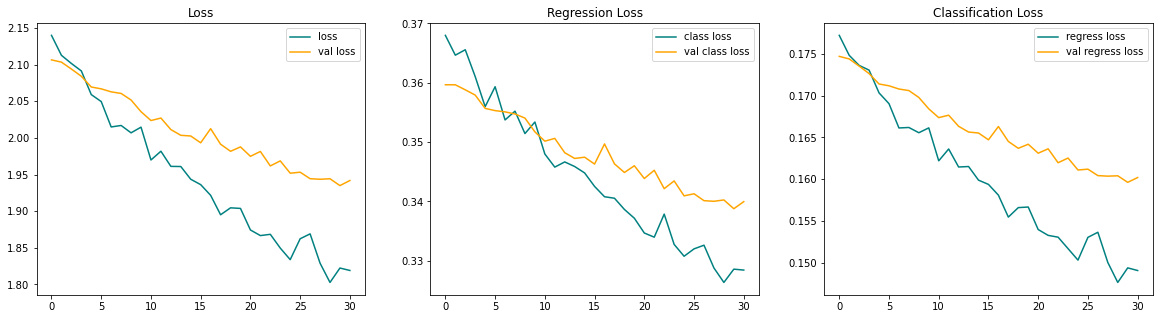

In [52]:
#mv2 fine
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['bbox_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_bbox_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Regression Loss')
ax[1].legend()

ax[2].plot(hist.history['face_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_face_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Classification Loss')
ax[2].legend()

plt.show()

### global max fine-tuning

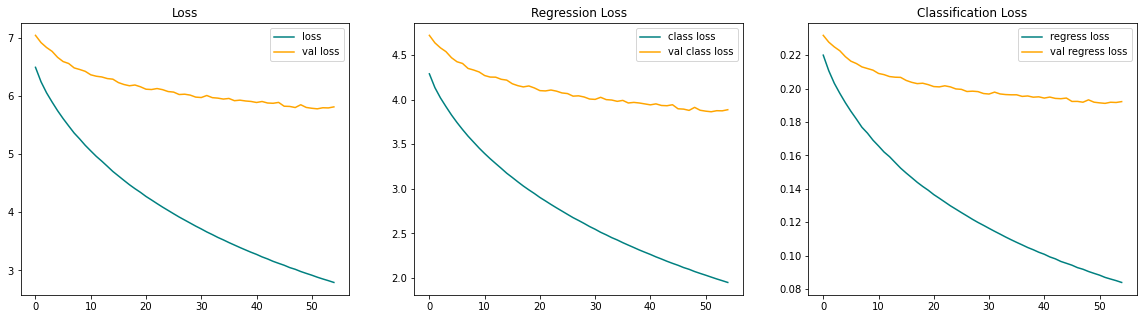

In [31]:
#mv2 fine
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['bbox_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_bbox_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Regression Loss')
ax[1].legend()

ax[2].plot(hist.history['face_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_face_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Classification Loss')
ax[2].legend()

plt.show()

In [15]:
val_data = val.as_numpy_iterator()

In [26]:
val_sample = val_data.next()

In [27]:
yhat = model.predict(val_sample[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


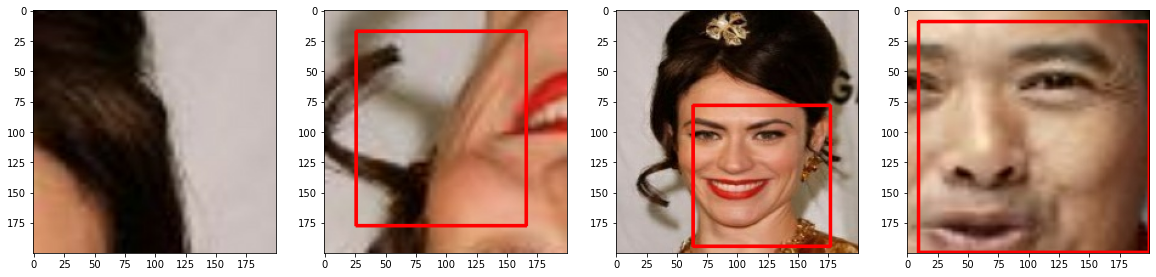

In [28]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
idx = 0

for i in range(4):
    sample_image = val_sample[0][idx]
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.5:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [200,200]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [200,200]).astype(int)), 
                            (255,0,0), 2)
    ax[i].imshow(sample_image)
    idx += 1

# for idx in range(16):
#     sample_image = test_sample[0][idx]
#     sample_coords = yhat[1][idx]
    
#     if yhat[0][idx] > 0.9:
#         cv2.rectangle(sample_image, 
#                       tuple(np.multiply(sample_coords[:2], [100,120]).astype(int)),
#                       tuple(np.multiply(sample_coords[2:], [100,120]).astype(int)), 
#                             (255,0,0), 2)
#     ax[idx].imshow(sample_image)

In [237]:
test_sample = val_data.next()
yhat = model.predict(val)

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(20,20))
idx = 0

for i in range(2):
  for j in range(4):
    sample_image = val_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.5:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [100,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [100,120]).astype(int)), 
                            (255,0,0), 2)
    ax[i][j].imshow(sample_image)
    idx += 1

# for idx in range(16):
#     sample_image = test_sample[0][idx]
#     sample_coords = yhat[1][idx]
    
#     if yhat[0][idx] > 0.9:
#         cv2.rectangle(sample_image, 
#                       tuple(np.multiply(sample_coords[:2], [100,120]).astype(int)),
#                       tuple(np.multiply(sample_coords[2:], [100,120]).astype(int)), 
#                             (255,0,0), 2)
#     ax[idx].imshow(sample_image)

In [2]:
from tensorflow.keras.models import load_model

In [100]:
model.save('model_v2_keras')

INFO:tensorflow:Assets written to: model_v2_keras\assets


E:\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [97]:
tf.saved_model.save(model, 'model_v2')

INFO:tensorflow:Assets written to: model_v2\assets


In [98]:
converter = tf.lite.TFLiteConverter.from_saved_model('model_v2') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model_v2.tflite', 'wb') as f:
  f.write(tflite_model)

In [185]:
loaded = tf.saved_model.load('model')
print(list(loaded.signatures.keys()))

['serving_default']


In [192]:
model.save_weights('model_weights.h5')

In [194]:
savedModel = model.load_weights('model_weights.h5')
print('Model Loaded!')

Model Loaded!


In [4]:
model = load_model('model_v2_keras', custom_objects={'localization_loss': localization_loss})

In [5]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
MobilenetV3small (Functional)   (None, 1, 1, 1024)   1529968     input_5[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_7 (Glo (None, 1024)         0           MobilenetV3small[0][0]           
__________________________________________________________________________________________________
global_average_pooling2d_8 (Glo (None, 1024)         0           MobilenetV3small[0][0]           
____________________________________________________________________________________________

In [7]:
!tensorflowjs_converter --input_format=tf_saved_model model_v2_keras web_model

Writing weight file web_model\model.json...


2022-05-26 18:10:15.372233: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-26 18:10:22.368488: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2149 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5
2022-05-26 18:10:46.921161: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-05-26 18:10:46.942835: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-05-26 18:10:47.298757: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 w